In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [102]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [217]:
C = torch.randn((27, 2)) # Embedding matrix, each 27 character represented by 2D vector

W1 = torch.randn(6, 300) # (6, 100) matrix, chose 100 as our "hidden layer size" 
b1 = torch.randn(300)
W2 = torch.randn((300, 27))
b2 = torch.randn(27)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [182]:
# train 80%, validation 10%, test 10%
def eval_loss (X, Y):
    emb = C[X] # (B, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss.item()

In [241]:
def forward_pass(C, W1, b1, W2, b2, lossi=[], stepi=[], iters=1000):
    # lre = torch.linspace(-3, 0, 1000)
    # parameters = [C, W1, b1, W2, b2]
    
    for i in range(iters):
        ix = torch.randint(0, Xtr.shape[0], (2048, ))
        
        emb = C[Xtr[ix]] # (32, 3, 2) as we are using trigrams, so 3 characters to predict the next character
        h = torch.tanh(emb.view(-1, block_size * C.shape[-1]) @ W1 + b1 ) #(B x 100) First layer of non-linearity
        logits = h @ W2 + b2 # Matrix calculations becore softmax
        loss = F.cross_entropy(logits, Ytr[ix]) # Cross entropy does softmax internally and solves it

        for p in parameters:
            p.grad = None

        loss.backward()
        # lr = lrs[i]
        lr = 0.1 if i < 10000 else 0.01
        for p in parameters:
            p.data += -1*lr * p.grad

        # track stats
        stepi.append(i)
        lossi.append(loss.log10().item())
    
    return loss


In [222]:
C = torch.randn((27, 2)) # Embedding matrix, each 27 character represented by 2D vector

W1 = torch.randn(6, 300) # (6, 100) matrix, chose 100 as our "hidden layer size" 
b1 = torch.randn(300)
W2 = torch.randn((300, 27))
b2 = torch.randn(27)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

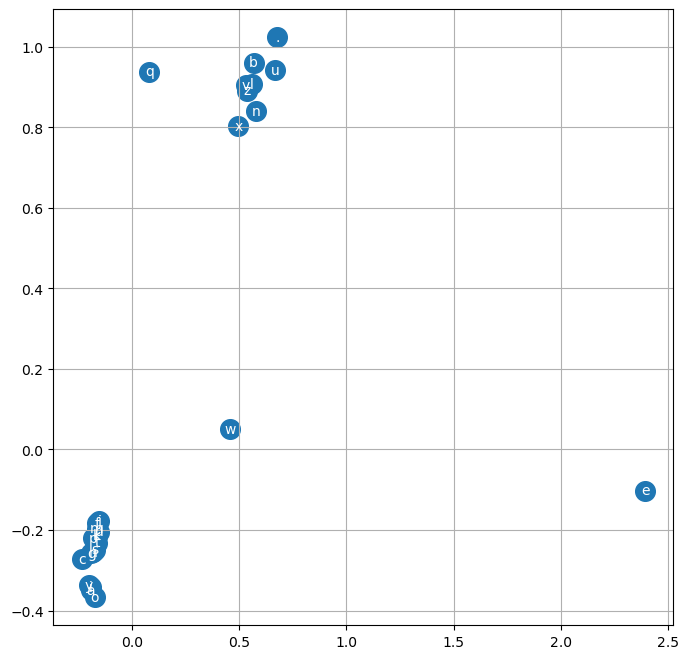

In [221]:
# 2D visualize character embeddings

plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color='white')

plt.grid('minor')

In [231]:
lossi = []
stepi = []

In [232]:
#Increase dimension of embeddings
C = torch.randn((27, 10)) # Embedding matrix, each 27 character represented by 2D vector

W1 = torch.randn(30, 200) # (6, 100) matrix, chose 100 as our "hidden layer size" 
b1 = torch.randn(200)
W2 = torch.randn((200, 27))
b2 = torch.randn(27)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True


In [242]:
loss = forward_pass(C, W1, b1, W2, b2, lossi, stepi, iters=20000)
print(loss.item())

2.2460479736328125


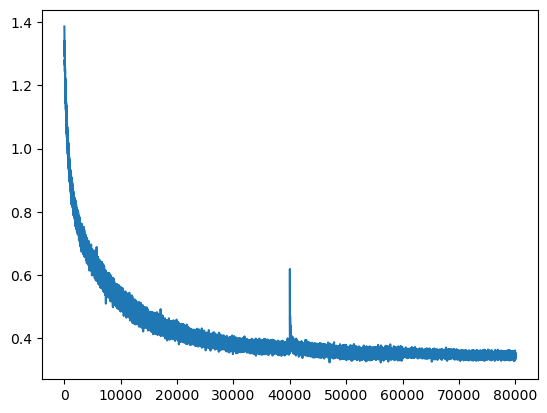

In [243]:
plt.plot(torch.arange(0, len(lossi), step=1), lossi)

In [271]:
def generate_name(num):
    for _ in range(num):
        context = [0] * block_size
        name = ""

        while True:
            embd = C[torch.tensor(context)] # (1, blocksize, embed_size)
            h = torch.tanh(embd.view(-1, block_size * C.shape[-1]) @ W1 + b1)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)

            ix = torch.multinomial(probs, 1).item()
            
            if ix == 0:
                break
            
            name += itos[ix]
            context = context[1:] + [ix]
            
        print(name)


generate_name(10)

rachigleh
fiarga
jusan
saleniten
mryn
nay
karloni
tessmanni
lackuley
jona


The wor